# Cosine similarity metric

In this research, cosine similarity was utilized as follows:

- For each pair of (LLM response, annotator label) for an entry, the cosine similarity matrix was computed.
- The similarity value of elements with similarity below 0.2 was set to 0, indicating no significant similarity.
- The highest similarity value in the matrix was selected for each LLM response.
- The similarity values were averaged across the entire dataset.
- The similarity values were further averaged over 10 different runs.

In [2]:
import re
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# extract required data per annotator
def extract_data_per_annotator(annotator_number):
    file_path = f'data_extraction/personal_annotation_{annotator_number}.json'

    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    return data

In [4]:
# extract llm result data per annotator
%run process_answer.ipynb
def get_llm_result_data(annotator_number, llm_method):
    annotator_data = extract_data_per_annotator(annotator_number)
    llm_result = process_and_store_llm_answers(f'llm_responses/{llm_method}.json')

    return annotator_data, llm_result

In [21]:
def compute_cosine_similarity(number_of_entries, annotator_number, samples_used_for_training, llm_method):
    """
    Computes the averaged cosine similarity score for the chosen LLM method and annotator over the dataset.

    Args:
        number_of_entries: number of dataset entries
        annotator_number: chosen annotator number
        samples_used_for_training: dataset entries used for training
        llm_method: chosen llm method

    Returns: the averaged cosine similarity

    """
    dataset_average_cosine_similarity = 0
    annotator_data, llm_result = get_llm_result_data(annotator_number, llm_method)

    average_similarity_all_runs = 0
    for j in range(0, 10):
        for i in range(0, number_of_entries):
            # exclude entries used for training
            if i in samples_used_for_training:
                continue

            # llm response
            llm_response= llm_result[j][i]
            if len(llm_response) == 0:
                llm_response.append('None')

            # don't consider faulty responses
            if len(llm_response) >= 2:
                for response in llm_response:
                    if response == "None" or response == "":
                        llm_response.remove(response)


            # annotator data
            annotator_response = annotator_data.get("labels")[i]


            vectorizer = TfidfVectorizer().fit(llm_response + annotator_response)
            tfidf_llm_response= vectorizer.transform(llm_response)
            tfidf_annotator_response = vectorizer.transform(annotator_response)

            # compute similarity matric
            similarity_matrix = cosine_similarity(tfidf_llm_response, tfidf_annotator_response)

            # Adjust similarities and compute the highest value for each row
            similarity_sum = 0
            for i, row in enumerate(similarity_matrix):
                adjusted_row = [sim if sim >= 0.2 else 0 for sim in row]
                highest_similarity = max(adjusted_row)
                similarity_sum += highest_similarity


            average_similarity = np.round(similarity_sum/(len(llm_response)), 5)
            dataset_average_cosine_similarity += average_similarity

        dataset_average_cosine_similarity = np.round(dataset_average_cosine_similarity/(number_of_entries - len(set(samples_used_for_training))), 4)
        average_similarity_all_runs += dataset_average_cosine_similarity

    average_similarity_all_runs = np.round(average_similarity_all_runs/10, 3)
    return average_similarity_all_runs

In [24]:
# zero shot no policy for all annotators
def zero_shot_no_policy():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'zero_shot_no_policy_options'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, llm_method))

    return annotators_cosine_similarity

In [25]:
# zero shot with policy for all annotators
def zero_shot():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'zero_shot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, llm_method))

    return annotators_cosine_similarity

In [39]:
# zero shot chain of thought for all annotators
def zero_shot_cot():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'zero_shot_cot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, llm_method))

    return annotators_cosine_similarity

In [26]:
# few shot no policy for all annotators
def few_shot_no_policy():
    number_of_entries = 50
    samples_used_for_training = [0, 3, 12]
    llm_method = 'few_shot_no_policy'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [27]:
# few shot with policy for all annotators
def few_shot():
    number_of_entries = 50
    samples_used_for_training = [0, 3, 12]
    llm_method = 'few_shot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [38]:
# few shot chain of thought for all annotators
def few_shot_cot():
    number_of_entries = 50
    samples_used_for_training = [0, 3, 12]
    llm_method = 'few_shot_cot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [37]:
# few shot majority vote for all annotators
def few_shot_majority_vote():
    number_of_entries = 50
    samples_used_for_training = [0, 3, 12]
    llm_method = 'few_shot_majority_vote'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}'))

    return annotators_cosine_similarity

In [13]:
# preprocess responses
def preprocess_string(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)  # replace multiple whitespace characters with a single space
    text = text.strip().lower()  # strip leading and trailing whitespace and convert to lowercase
    return text

In [14]:
def remove_results_same_as_training_few_shot(llm_method, samples_used_for_training, number_of_entries):
    """
    Removes data entries which the LLM overfit to and recomputes the cosine similarity.
    Args:
        llm_method: the llm method used
        samples_used_for_training: the data entries used for training
        number_of_entries: number of dataset entries

    Returns: the recomputed cosine similarity

    """
    annotators_cosine_similarity = []

    for q in range(0, 5):
        annotator_data, llm_result = get_llm_result_data(q + 1, f'{llm_method}_{q + 1}')
        remove_list = []
        for run in llm_result:
            for i, row in enumerate(run):
                if i in samples_used_for_training:
                    continue

                annotator_label = annotator_data.get('labels')[0]
                for k, y in enumerate(annotator_label):
                    annotator_label[k] = preprocess_string(y)

                intersection = set(row) & set(list(annotator_data.get('labels')[0]))


                if len(intersection) > 0:
                    remove_list.append(i)


        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, q + 1, set(samples_used_for_training + remove_list), f'{llm_method}_{q + 1}'))


    return annotators_cosine_similarity

In [28]:
# one shot no policy for all annotators
def one_shot_no_policy():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'one_shot_no_policy'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [29]:
# one shot with policy for all annotators
def one_shot():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'one_shot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [36]:
# one shot chain of thought for all annotators
def one_shot_cot():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'one_shot_cot'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}_{i + 1}'))

    return annotators_cosine_similarity

In [35]:
# one shot majority vote for all annotators
def one_shot_majority_vote():
    number_of_entries = 50
    samples_used_for_training = [0]
    llm_method = 'one_shot_majority_vote'

    annotators_cosine_similarity = []
    for i in range(0, 5):
        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, i + 1, samples_used_for_training, f'{llm_method}'))

    return annotators_cosine_similarity

In [19]:
# how many results are the same as the example
def remove_results_same_as_training_one_shot(llm_method, samples_used_for_training, number_of_entries):
    """
    Removes data entries which the LLM overfit to and recomputes the cosine similarity.
    Args:
        llm_method: the llm method used
        samples_used_for_training: the data entries used for training
        number_of_entries: number of dataset entries

    Returns: the recomputed cosine similarity

    """
    annotators_cosine_similarity = []

    for q in range(0, 5):
        annotator_data, llm_result = get_llm_result_data(q + 1, f'{llm_method}_{q + 1}')
        remove_list = []
        for run in llm_result:
            for i, row in enumerate(run):
                if i in samples_used_for_training:
                    continue

                annotator_label = annotator_data.get('labels')[0]
                for k, y in enumerate(annotator_label):
                    annotator_label[k] = preprocess_string(y)


                intersection = set(row) & set(list(annotator_data.get('labels')[0]))


                if len(intersection) > 0:
                    remove_list.append(i)


        annotators_cosine_similarity.append(compute_cosine_similarity(number_of_entries, q + 1, set(samples_used_for_training + remove_list), f'{llm_method}_{q + 1}'))

    return annotators_cosine_similarity

Running the cell below outputs a table showing results for the zero-shot, one-shot and few-shot prompting approaches, when no policy option is provided in the prompt

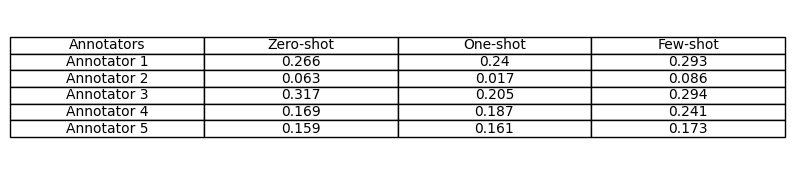

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# data for the table
data = {
    'Annotators': ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'],
    'Zero-shot': zero_shot_no_policy(),
    'One-shot': one_shot_no_policy(),
    'Few-shot': few_shot_no_policy()
}

# create a DataFrame
df = pd.DataFrame(data)

# plotting the table
fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# show the plot
plt.show()


Running the cell below outputs a table showing results for the zero-shot, one-shot and few-shot prompting approaches, when the policy option is provided in the prompt

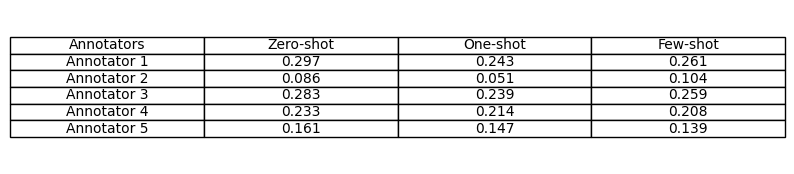

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# data for the table
data = {
    'Annotators': ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'],
    'Zero-shot': zero_shot(),
    'One-shot': one_shot(),
    'Few-shot': few_shot()
}

# create a DataFrame
df = pd.DataFrame(data)

# plotting the table
fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# show the plot
plt.show()

Running the cell below outputs a table showing results for the zero-shot, one-shot and few-shot prompting approaches, after the data entries the LLM overfitted to were removed

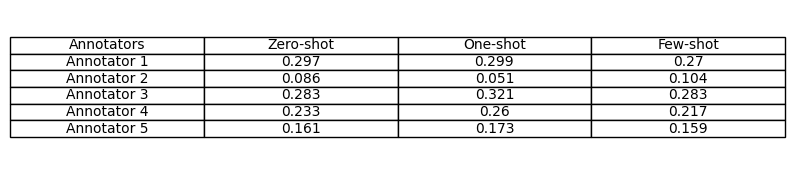

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# data for the table
data = {
    'Annotators': ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'],
    'Zero-shot': zero_shot(),
    'One-shot': remove_results_same_as_training_one_shot('one_shot', [0], 50),
    'Few-shot': remove_results_same_as_training_few_shot('few_shot', [0, 3, 12], 50)
}

# create a DataFrame
df = pd.DataFrame(data)

# plotting the table
fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# show the plot
plt.show()

Running the cell below outputs a table showing results for the zero-shot, one-shot and few-shot prompting approaches, with or without applying chain-of-thought prompting

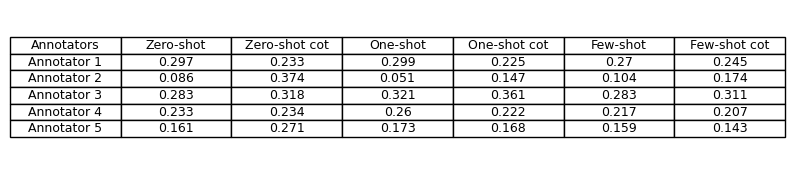

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# data for the table
data = {
    'Annotators': ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'],
    'Zero-shot': zero_shot(),
    'Zero-shot cot': zero_shot_cot(),
    'One-shot': remove_results_same_as_training_one_shot('one_shot', [0], 50),
    'One-shot cot': remove_results_same_as_training_few_shot('one_shot_cot', [0], 50),
    'Few-shot': remove_results_same_as_training_few_shot('few_shot', [0, 3, 12], 50),
    'Few-shot cot': remove_results_same_as_training_few_shot('few_shot_cot', [0, 3, 12], 50)
}

# create a DataFrame
df = pd.DataFrame(data)

# plotting the table
fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# show the plot
plt.show()

Running the cell below outputs a table showing results for the one-shot and few-shot prompting approaches, with individual annotator labels and with majority vote labels

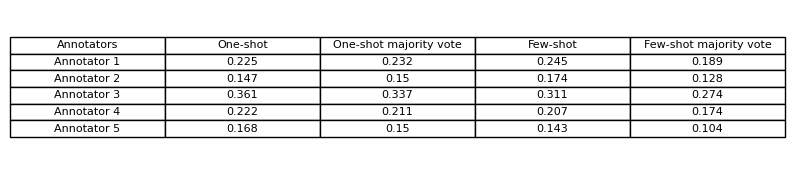

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# data for the table
data = {
    'Annotators': ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5'],
    'One-shot': remove_results_same_as_training_one_shot('one_shot_cot', [0], 50),
    'One-shot majority vote': one_shot_majority_vote(),
    'Few-shot': remove_results_same_as_training_few_shot('few_shot_cot', [0, 3, 12], 50),
    'Few-shot majority vote': few_shot_majority_vote()
}

# create a DataFrame
df = pd.DataFrame(data)

# plotting the table
fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# show the plot
plt.show()